In [ ]:
from google.colab import drive
drive.flush_and_unmount()


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, LayerNormalization, Bidirectional, Input
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from tensorflow.keras.regularizers import l2

# Load EEG Data
data = pd.read_csv("/content/drive/MyDrive/EEG_dataset/EEG.machinelearing_data_BRMH.csv")

target_column = "specific.disorder"
y = data[target_column].astype(str)  # Convert labels to string




# Drop non-numeric columns
X = data.drop(columns=[target_column,'no.','age','education','IQ']).select_dtypes(include=[np.number])

# Fill missing values with median
X.fillna(X.median(), inplace=True)

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)  # One-hot encoding

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA for feature reduction
'''pca = PCA(n_components=100)  # Keeping 100 most important features
X_pca = pca.fit_transform(X_scaled)
'''
smote = SMOTE(random_state=42)
X_resampled,y_resampled=smote.fit_resample(X_scaled, y_encoded)

y_categorical_resampled = to_categorical(y_resampled)

# Convert to NumPy arrays
X_resampled = np.array(X_resampled)
y_categorical_resampled = np.array(y_categorical_resampled)
# Reshape features for RNN
num_samples, num_features = X_resampled.shape
time_steps = 30  # Increase time steps for better temporal representation
X_reshaped = X_resampled.reshape((num_samples, time_steps, num_features // time_steps))

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y_categorical_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)
def augment_eeg_data(X):
    noise = np.random.normal(0, 0.05, X.shape)
    scale = np.random.uniform(0.9, 1.1, (X.shape[0], 1, X.shape[2]))
    X_augmented = X * scale + noise
    return X_augmented

# Apply augmentation to the training set
X_train = augment_eeg_data(X_train)


In [ ]:

def create_improved_gru(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),

        Bidirectional(GRU(512, return_sequences=True, kernel_initializer='glorot_uniform',
                          kernel_regularizer=l2(1e-5))),
        LayerNormalization(),
        Dropout(0.5),

        Bidirectional(GRU(256, return_sequences=True, kernel_initializer='glorot_uniform',
                          kernel_regularizer=l2(1e-4))),
        LayerNormalization(),
        Dropout(0.4),

        Bidirectional(GRU(128, return_sequences=False, kernel_initializer='glorot_uniform',
                          kernel_regularizer=l2(1e-3))),
        LayerNormalization(),
        Dropout(0.4),

        Dense(128, activation="relu", kernel_initializer='he_normal', kernel_regularizer=l2(1e-4)),
        Dropout(0.3),

        Dense(num_classes, activation="softmax", kernel_regularizer=l2(1e-4))
    ])

    return model

Training Improved GRU model...
Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.0988 - loss: 4.8308 - val_accuracy: 0.1632 - val_loss: 3.5123 - learning_rate: 2.0000e-04
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.1095 - loss: 4.1022 - val_accuracy: 0.1987 - val_loss: 3.4354 - learning_rate: 2.0000e-04
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.1135 - loss: 3.9043 - val_accuracy: 0.2197 - val_loss: 3.3575 - learning_rate: 2.0000e-04
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.1504 - loss: 3.7180 - val_accuracy: 0.2092 - val_loss: 3.3531 - learning_rate: 2.0000e-04
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.1546 - loss: 3.5875 - val_accuracy: 0.2427 - val_loss: 3.3279 - learning_rate: 2.0000e-04
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.1514 - loss: 3.5253 - val_accuracy: 0.2322 - val_loss: 3.3184 - learning_rate: 2.0000e-04
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━

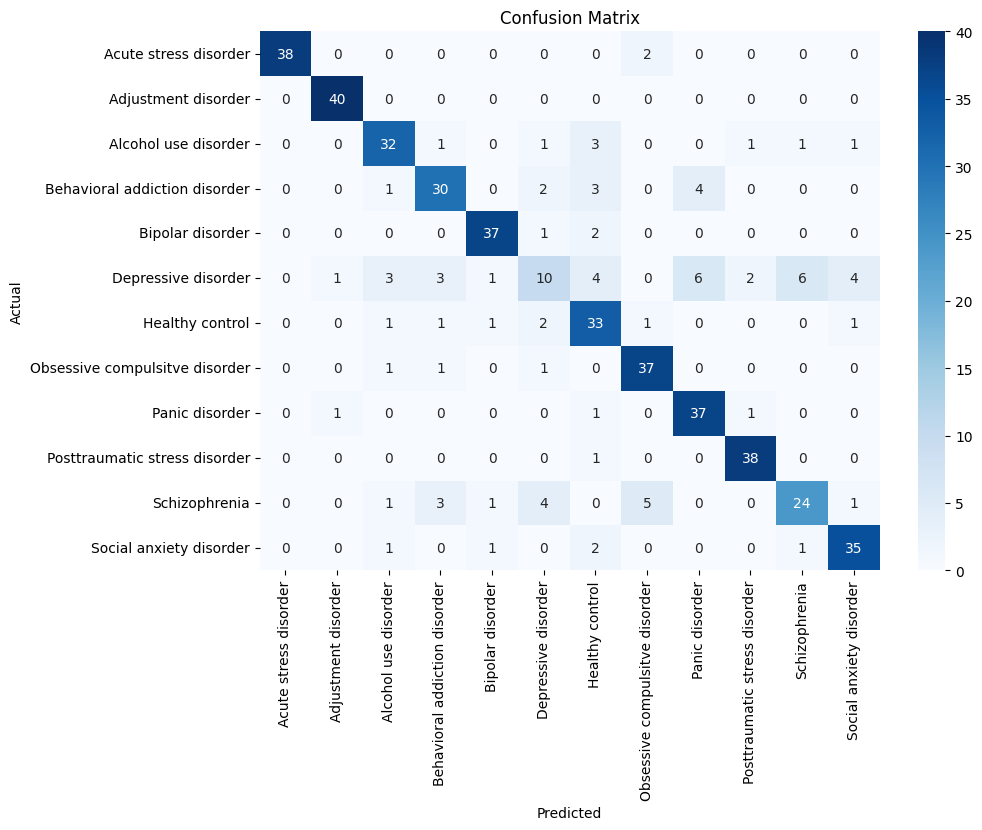

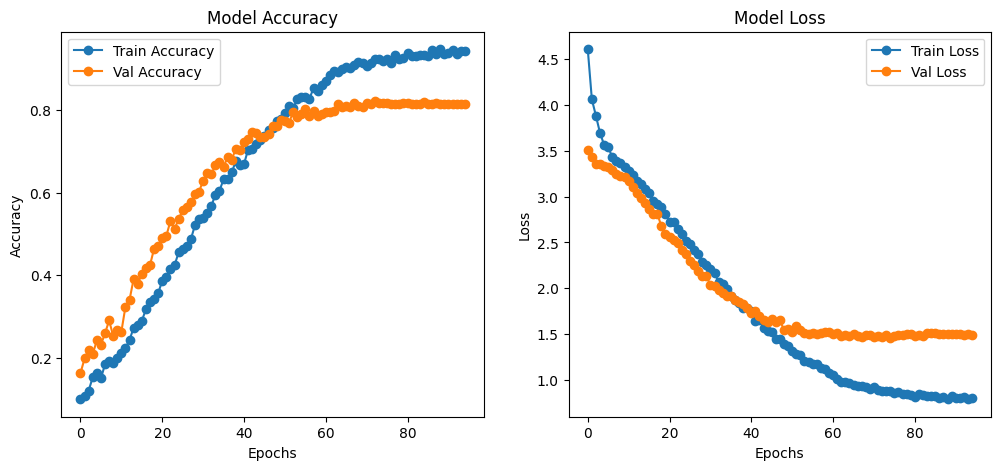

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Create and compile the model
input_shape = (time_steps, num_features // time_steps)
num_classes = y_categorical_resampled.shape[1]
model = create_improved_gru(input_shape, num_classes)

optimizer = AdamW(learning_rate=0.0002, weight_decay=1e-5)

lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
# Create a mask to filter out "Depressive Disorder"
import numpy as np



y_train_labels = np.argmax(y_train, axis=1)

class_labels = np.unique(y_train_labels)  # Replace y_train with your labels
class_weights = compute_class_weight("balanced", classes=class_labels, y=y_train_labels)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Train model with class weights

model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)

# Callbacks: Early Stopping & Learning Rate Reduction
callbacks = [
    EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True),
    lr_schedule
]

# Train the model
print("Training Improved GRU model...")
history = model.fit(
    X_train, y_train,
    epochs=100, batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# Evaluate the model
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_actual = np.argmax(y_test, axis=1)

# Print evaluation metrics
print("\nImproved GRU Accuracy:", accuracy_score(y_test_actual, y_pred))
print("\nClassification Report:\n", classification_report(y_test_actual, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_actual, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Plot Training Curves
def plot_training_curves(history):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy", marker="o")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Model Accuracy")

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss", marker="o")
    plt.plot(history.history["val_loss"], label="Val Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Model Loss")

    plt.show()

plot_training_curves(history)


In [ ]:
model.save("/content/drive/MyDrive/best_eeg_model.h5")


#Evaluation

In [ ]:
# Predict class probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_actual = np.argmax(y_test, axis=1)

# Compute accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test_actual, y_pred)
print(f"GRU Accuracy: {accuracy:.4f}")


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
GRU Accuracy: 0.8180


In [ ]:
from sklearn.metrics import classification_report

print("\nGRU Classification Report:\n")
print(classification_report(y_test_actual, y_pred, target_names=label_encoder.classes_))



GRU Classification Report:

                                precision    recall  f1-score   support

         Acute stress disorder       0.97      0.95      0.96        40
           Adjustment disorder       0.98      1.00      0.99        40
          Alcohol use disorder       0.82      0.80      0.81        40
 Behavioral addiction disorder       0.74      0.80      0.77        40
              Bipolar disorder       0.90      0.90      0.90        40
           Depressive disorder       0.52      0.38      0.43        40
               Healthy control       0.66      0.82      0.73        40
Obsessive compulsitve disorder       0.79      0.93      0.85        40
                Panic disorder       0.95      0.95      0.95        40
 Posttraumatic stress disorder       0.81      0.90      0.85        39
                 Schizophrenia       0.80      0.51      0.62        39
       Social anxiety disorder       0.83      0.88      0.85        40

                      accuracy   

In [ ]:
from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score(y_test, y_pred_probs, multi_class="ovr")
print(f"ROC-AUC Score: {auc_score:.4f}")


ROC-AUC Score: 0.9718


In [ ]:
import numpy as np

def preprocess_input(raw_input, scaler, pca, time_steps, num_features):
    """
    Preprocesses the raw input:
    1. Standardizes it using the trained scaler.
    2. Applies PCA for dimensionality reduction.
    3. Reshapes it to match the GRU model input.
    """
    # Convert to NumPy array and reshape if necessary
    raw_input = np.array(raw_input).reshape(1, -1)  # Convert single input to 2D array

    # Standardize using the trained scaler
    input_scaled = scaler.transform(raw_input)

    # Apply PCA
    input_pca = pca.transform(input_scaled)

    # Reshape input to match (time_steps, num_features//time_steps)
    input_reshaped = input_pca.reshape(1, time_steps, num_features // time_steps)

    return input_reshaped

def predict_disorder(model, raw_input, scaler, pca, label_encoder, time_steps, num_features):
    """
    Takes raw EEG features, preprocesses them, and predicts the disorder.
    """
    # Preprocess input
    processed_input = preprocess_input(raw_input, scaler, pca, time_steps, num_features)

    # Make prediction
    prediction_probs = model.predict(processed_input)

    # Get the predicted class
    predicted_class_idx = np.argmax(prediction_probs, axis=1)

    # Convert numerical class back to original label
    predicted_class_label = label_encoder.inverse_transform(predicted_class_idx)

    return predicted_class_label[0]


In [ ]:
#SampleData
12.159137,13.113503,9.031007,14.879389,15.83483,19.595759,11.605911,6.084709,13.159062,16.848773,14.015103,8.283439,4.594446,10.957161,12.249199,10.562645,8.489141,6.404962,7.23517,7.829772,8.89498,6.519044,11.106882,12.148242,11.430233,6.861712,4.750089,9.32456,11.644291,10.348482,5.751727,2.840736,7.82947,8.49089,7.999637,4.48155,4.857487,5.406491,24.877439,26.939986,19.164824,32.776782,36.686694,34.741534,22.860706,12.501867,33.452792,42.733322,36.676051,18.321642,9.485397,28.346261,36.72406,26.81463,12.072228,22.617391,21.120044,4.256582,4.375999,3.78038,5.298075,5.528563,6.421384,5.029728,3.306942,8.193191,6.393206,7.76091,4.45914,2.168419,6.313913,6.592705,5.845611,3.45431,3.888247,4.242814,0.804693,0.639437,0.810462,0.872661,0.737553,0.957681,1.033361,0.413274,0.941063,0.765235,0.835256,0.933639,0.270185,0.632236,0.615763,0.645,0.502085,0.427056,0.489519,0.872743,0.739127,0.898192,0.78656,0.768897,1.077768,1.691943,0.919724,0.851136,0.786004,1.008961,1.710315,0.424351,0.767291,0.65162,0.695028,0.599125,0.505596,0.581558,69.208495,58.84084,58.766375,40.695983,40.512774,39.476688,10.565545,19.55127,20.332399,14.580601,4.329545,8.973737,5.491336,7.857995,5.546955,5.97857,3.767373,5.129204,39.973504,39.900109,58.92364,58.778343,58.63867,5.904578,15.697985,19.71316,18.235475,10.041742,5.37151,3.561624,6.850398,5.038008,5.273283,1.978024,4.884622,99.950848,28.355567,27.917264,25.955318,23.488442,32.093799,28.654332,16.372743,2.660475,23.853381,13.651007,16.03014,9.061178,5.892036,11.348507,9.823307,28.471044,28.031818,26.059053,23.459927,32.247356,28.764856,16.438824,2.701173,23.918001,13.68713,16.167522,9.176463,5.958641,11.409103,9.899201,99.925804,99.657719,3.462452,25.175491,39.120161,37.428886,23.760678,7.787394,8.967623,18.322328,17.999642,17.754563,6.073311,11.878865,99.697858,3.439537,24.797853,38.824994,37.310668,23.805957,7.721358,8.925741,18.133544,17.878754,17.651827,6.00371,11.711843,3.148778,23.28226,36.524855,36.16095,24.731978,7.021206,8.12956,16.786849,16.984913,17.625974,5.544213,11.411265,10.044386,3.851192,3.270002,0.610538,20.815296,9.358317,4.241809,1.510354,0.902683,9.12529,4.575745,40.306282,20.399109,3.255295,27.188795,24.307055,29.580921,17.876349,10.439679,15.713592,13.419867,37.855233,5.467605,20.612447,26.933446,45.634082,32.601607,17.057105,17.766303,19.361947,8.065559,11.132624,18.052261,30.977623,29.170033,17.910625,10.235761,17.111177,2.731032,2.500464,4.862805,8.183254,17.493839,3.406449,8.0854,50.241275,43.187641,21.178859,18.911851,50.065098,29.371924,52.271365,28.893455,19.143914,41.152988,26.066895,66.835592,43.516215,56.461931,51.720479,47.620093,34.843409,43.623373,47.736728,66.039023,60.786822,83.977024,76.781935,76.809995,66.432834,66.316416,65.487359,19.407865,43.31696,47.14833,40.281265,16.380834,4.701054,11.22979,13.616071,9.431932,1.140557,0.410566,2.526262,60.036739,60.04317,77.088755,77.129366,76.992223,10.826362,35.824514,43.215232,42.710993,22.753214,2.271557,8.580411,12.300247,9.908819,1.600022,0.177102,2.231994,99.94861,56.132011,55.868502,54.715009,30.895586,59.147507,51.304015,38.717409,11.074515,9.891235,16.39079,15.10616,8.915405,1.006914,1.117815,2.086922,56.249251,55.981069,54.816369,30.772595,59.231092,51.476195,38.818548,11.065658,9.895914,16.419144,15.187879,8.979293,1.027157,1.128678,2.086424,99.931655,99.763084,8.025425,42.851177,61.51389,62.405217,35.367305,2.466021,11.73704,20.689059,19.475548,5.120811,0.342645,4.567629,99.801936,7.984805,42.572813,61.131895,62.416823,35.711332,2.454517,11.624067,20.536295,19.374171,5.122665,0.33871,4.549562,7.869683,41.342786,59.558706,61.913631,37.172066,2.214197,11.086134,19.924969,19.185991,5.237556,0.266147,4.473307,23.507609,10.983573,7.188168,1.555508,26.175121,13.476614,4.667588,0.999824,3.206155,3.231785,1.017703,56.671695,39.803311,9.377605,19.751366,32.742321,31.971275,17.637506,2.967581,7.146659,6.749175,61.633591,17.888706,8.537022,27.166911,46.714011,35.619129,8.938266,5.511903,13.221882,27.130518,4.793918,18.259503,37.546211,39.274417,12.382958,3.076829,12.463924,0.259637,2.22823,8.950321,16.217106,19.230333,0.063836,6.100591,53.554225,18.695563,3.348336,0.235534,44.808245,8.591389,54.038613,22.380503,6.974801,47.780974,23.221074,63.300265,28.102183,37.908735,49.187452,45.54111,14.655458,43.954729,18.117721,56.094186,48.037249,97.403766,95.794281,95.808059,91.357708,91.312009,90.927563,74.586621,83.322552,81.654554,72.477732,30.752824,4.436048,5.766284,16.439849,2.158328,42.125302,26.927739,20.985339,92.61484,92.615543,94.364486,94.336749,94.120568,71.232854,81.248486,81.071034,74.676899,34.293084,3.880582,5.662655,16.3034,2.22586,41.616339,27.064885,20.788177,99.984986,89.976893,89.890723,89.500115,80.072528,89.156801,84.128253,74.373293,31.917961,6.581861,7.387728,18.199614,3.022278,40.159707,24.284307,19.462207,89.997876,89.910603,89.518982,80.042479,89.191844,84.14937,74.41941,31.943373,6.563319,7.389021,18.221398,3.045904,40.086884,24.295431,19.406042,99.983499,99.94539,68.305918,84.200593,85.98733,85.788608,47.484697,5.09136,6.324367,18.871384,4.829513,35.659708,24.802722,16.867038,99.954244,68.204862,84.068114,85.886468,85.757224,47.603954,5.051122,6.288128,18.828395,4.816618,35.655994,24.855606,16.877613,67.961355,83.668592,85.392446,85.555845,48.628682,4.959251,6.18812,18.581527,4.736514,35.500618,25.095578,17.027602,74.700962,65.83163,56.199174,21.005269,14.994867,8.152623,15.014503,1.407727,43.44811,17.198283,21.685255,88.575138,78.921273,34.871597,14.712229,16.301682,27.307812,8.721802,28.334172,12.868666,10.096286,85.968036,36.160751,10.537896,12.692498,32.700043,14.702249,25.083626,13.833456,7.110335,48.601685,10.074704,13.591536,33.485577,21.117343,18.201525,10.97484,4.17852,1.308461,3.184985,7.994292,9.193053,2.067467,14.004646,3.133252,64.460318,23.509254,9.756115,4.020195,31.64113,7.321443,60.296495,24.623473,4.298787,39.846186,17.930812,57.35985,8.544723,22.045452,31.435048,16.219839,8.677514,37.50061,28.681276,63.231329,59.077948,87.509774,85.667039,85.715901,73.471194,73.28333,72.378709,38.744382,54.442834,52.058782,35.066346,19.56154,4.611001,5.669625,2.828346,1.246451,1.732925,1.137461,0.268867,70.113904,70.163389,84.385806,84.277108,83.955793,28.221784,44.296437,49.109071,38.14039,27.040779,2.481452,3.764481,2.183393,1.009722,1.133065,0.965267,0.089025,99.903343,61.381819,61.170517,60.043789,53.435665,68.948392,54.1605,32.792922,14.507531,9.690327,10.573125,4.644887,1.422126,1.804785,1.197022,0.323071,61.454889,61.244997,60.107754,53.356368,68.904807,54.211529,32.849167,14.496294,9.656743,10.51508,4.618938,1.421485,1.819434,1.169348,0.322235,99.884534,99.768636,23.180228,44.61145,61.446218,60.385864,42.16232,2.088474,4.413585,5.48442,3.544276,1.296079,0.449205,0.462962,99.797442,23.11378,44.40992,61.189729,60.407442,42.503379,2.064451,4.357748,5.441111,3.55644,1.331051,0.458029,0.471286,22.671352,43.34118,59.69426,59.810164,43.885039,1.918451,4.129123,5.155613,3.395496,1.361967,0.462197,0.438505,44.672063,23.141693,12.274388,4.957906,24.730923,13.434107,2.30948,0.846591,3.131019,2.26922,0.444689,62.5372,35.549988,9.980092,22.284398,28.653135,15.863031,4.441763,0.875631,4.37963,1.458387,66.434788,18.189158,9.694434,20.005089,31.33255,19.383718,2.298001,3.64061,8.095011,31.665034,3.684309,10.939356,25.859693,30.234799,10.533898,2.185662,11.645752,0.018393,0.28134,2.130397,4.762451,16.856282,0.11159,3.748337,70.567443,19.338744,2.412399,0.491533,56.332045,8.187817,50.252662,14.350711,4.137041,59.834929,19.711384,60.347019,20.868632,45.480325,60.951431,40.666036,15.241158,55.790417,15.881418,59.256714,51.110867,72.520128,75.260783,75.173622,59.575984,59.2773,59.016117,38.293316,34.418081,39.572136,31.351333,35.063833,27.123144,21.622509,21.200735,12.933773,25.47669,26.460094,28.899372,49.072064,49.0566,71.037344,70.931257,71.400648,25.638274,25.097836,35.896488,30.792098,39.675075,20.197131,17.294728,17.941057,11.91455,23.321763,20.769674,25.052734,99.729327,48.890458,48.503104,47.899835,50.25439,49.912916,43.300465,30.747606,30.48883,36.213313,28.163234,24.699452,12.906363,25.099003,31.09447,30.555628,48.801007,48.416739,47.822136,50.168163,49.957442,43.349788,30.639163,30.404766,36.210661,28.110558,24.673435,12.831851,25.135321,31.104601,30.485248,99.662531,99.515186,29.613198,34.268731,58.41593,59.998876,58.696816,26.259207,23.709209,30.121657,23.419376,37.982371,29.05344,38.381897,99.53966,29.573806,34.136178,58.301295,60.054111,58.845249,26.342944,23.776482,30.156455,23.5337,38.033378,29.135143,38.375764,29.550138,33.510038,56.713692,59.715845,60.338737,26.365823,23.871848,30.275901,23.585601,38.768239,29.451502,38.892723,43.718589,29.865274,24.396767,30.379111,59.064061,41.786152,29.399883,13.907349,31.456328,48.570848,41.913433,53.340119,32.90329,23.390053,46.789796,46.286816,36.642968,15.98563,23.640592,36.657708,32.059075,62.110023,35.322245,33.993149,38.280998,47.384062,33.599897,31.906752,32.919905,37.83446,48.253049,26.254113,27.466831,43.459755,43.051038,43.276738,30.332971,42.444499,32.406866,25.54926,34.694002,30.689504,58.736771,41.139249,54.878627,74.794438,54.748018,23.104249,39.893865,79.781167,57.330736,68.853679,28.066374,32.660762,69.488798,49.468571,61.899466,50.583007,67.535382,68.172397,51.366381,35.172004,54.125767,59.615318,81.993693,81.997799,74.349591,78.118699,78.253619,68.533797,68.647096,68.293133,50.894682,51.784568,49.938439,42.662265,49.721842,44.440823,37.757848,39.088947,26.929425,38.314114,43.420242,43.93509,60.466182,60.379789,78.222868,78.247755,78.54418,41.92654,43.962739,46.229586,44.456968,54.270399,39.084651,33.353021,36.293644,26.648749,37.919631,39.840202,41.992554,99.512964,63.308536,63.246552,62.716203,61.608974,62.959492,55.973113,42.858454,47.303247,52.648904,45.152913,44.756833,29.669226,40.824584,49.513852,48.754293,63.266263,63.20116,62.663829,61.384443,62.951482,55.918778,42.950475,47.353929,52.763516,45.275514,44.804713,29.643665,40.984245,49.752941,48.879161,99.498023,99.339793,48.400355,55.160332,65.57069,66.529227,71.204831,49.439915,45.25127,51.965427,42.109759,52.546209,52.23805,56.853201,99.397177,48.236287,54.969666,65.241398,66.362809,71.235937,49.231091,44.990199,51.698439,41.94312,52.401759,51.974203,56.731503,48.395579,54.330076,64.070233,66.009098,72.262592,49.204388,44.827664,51.535834,41.696093,52.635188,52.072226,56.80974,51.278313,42.593609,35.979489,43.836998,61.521946,49.920561,45.763728,28.091362,43.397375,57.79403,53.092989,63.903709,45.330932,42.210417,58.761885,57.912527,56.266774,34.824132,41.038585,54.481797,50.785252,61.348782,46.879495,52.220519,54.317898,63.134107,47.746698,44.141298,52.180067,53.156767,54.60339,40.639292,41.360538,54.148024,53.001407,47.916342,45.498823,50.969103,48.181496,42.373153,50.139833,43.211135,64.187942,55.980784,63.688444,78.524524,67.805081,38.213909,54.851889,84.524473,70.438041,77.336815,42.309728,48.60717,76.870243,63.38394,65.408894,59.590594,77.310851,75.280467,57.311188,48.015594,59.579033,68.50392,82.885151,86.986191
